## Lab 2: Optimizing Inference for Intel Hybrid Platforms

### Prerequisites: 
- Python3
- onnx
- onnxruntime
- numpy
- cv2 

### Lab Objectives: 
- Improve performance with intra/inter thread count configurations
- Reduce CPU utilization by setting spin loops to false
- Improving performance with INT8 optimizations
- Further improving performance of the model with ONNX Runtime optimization levels

### Let's start with a baseline of our performance with ResNet50

Import dependencies

In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt

Load the ResNet50 model

Ensure the model created from Lab 01 is located at the model_path

In [2]:
model_path = "../../models/resnet50.onnx"
model = onnx.load(model_path)
print("Model loaded!")

Model loaded!


>Create the runtime session and use *CPUExecutionProvider* to run on CPU with MLAS (Microsoft Linear Algebra Subroutine).

In [3]:
print("Available providers")
print(rt.get_available_providers())

sess = rt.InferenceSession(model_path, providers=['CPUExecutionProvider'])

Available providers
['CPUExecutionProvider']


Read a sample image to classify the object.

>Find the sample image under resources/ and read the image in.

Completed image pre-processing!


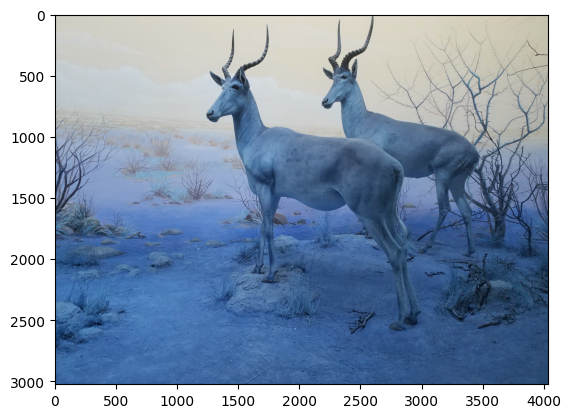

In [4]:
# Read the image
img = cv2.imread("../../resources/lab03_image.jpg")
plt.imshow(np.array(img))

# Preprocess the image for ResNet50. 
def preprocess(img):
    img = img / 255.
    img = cv2.resize(img, (256, 256))
    h, w = img.shape[0], img.shape[1]
    y0 = (h - 224) // 2
    x0 = (w - 224) // 2
    img = img[y0 : y0+224, x0 : x0+224, :]
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img = np.transpose(img, axes=[2, 0, 1])
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

img = preprocess(img)

print("Completed image pre-processing!")

Run inference with the sample image

In [5]:
input_name = sess.get_inputs()[0].name 
output_name = sess.get_outputs()[0].name 

prediction = sess.run(None, {input_name: img})[0]
prediction = np.squeeze(prediction)
top = np.argsort(prediction)[::-1]

# Read in human-readable class labels 
with open("../../resources/labels.txt", 'r') as f:
    labels = [l.rstrip() for l in f]

index = top[0]
print(index)
print("Predicted class:{0}  Probability: {1}".format(labels[index], prediction[index]))

353
Predicted class: 353: 'gazelle',  Probability: 10.210800170898438


Let's get an idea of our model's baseline performance by running the prediction loop 100x

In [6]:
import time 

start = time.time()
for i in range(100):
    prediction = sess.run(None, {input_name: img})[0]
end = time.time()
print("Total execution time of 100 inference sessions: {:.3f} seconds".format(end-start))

Total execution time of 100 inference sessions: 1.272 seconds


#### Now that we have our baseline performance with default options with ONNXRuntime, we will explore some of the optimizations that improve performance on hybrid systems. 

Let's improve performance with intra/inter thread count controls.

>For this lab, let's experiment with changing the value for intra op num threads to see how this impacts the performance. 

For additional help, please refer to: Thread Tuning - Low Precision Tuning section for an example

In [7]:
# Create session options to change different knobs for CPU (MLAS)
sess_option = rt.SessionOptions()
sess_option.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_BASIC
sess_option.intra_op_num_threads = 6
sess_option.inter_op_num_threads = 2
sess = rt.InferenceSession(model_path, providers=["CPUExecutionProvider"], sess_options=sess_option)

input_name = sess.get_inputs()[0].name 
output_name = sess.get_outputs()[0].name 

start = time.time()
for i in range(100):
    prediction = sess.run(None, {input_name: img})[0]
end = time.time()
print("Total execution time of 100 inference sessions: {:.3f} seconds".format(end-start))

Total execution time of 100 inference sessions: 3.462 seconds


In [8]:
start = time.time()
for i in range(100):
    prediction = sess.run(None, {input_name: img})[0]
end = time.time()
print("Total execution time of 100 inference sessions: {:.3f} seconds".format(end-start))

Total execution time of 100 inference sessions: 3.372 seconds


Next, we'll take advantage of ONNX Runtime's graph optimizations by setting it to all. \
>Change the Graph Optimization level to Enable All (ORT_ENABLE_ALL) \
>Hint: Try typing rt. and see what auto-completion brings

In [9]:


start = time.time()
for i in range(100):
    prediction = sess.run(None, {input_name: img})[0]
end = time.time()
print("Total execution time of 100 inference sessions: {:.3f} seconds".format(end-start))

Total execution time of 100 inference sessions: 3.699 seconds


Finally, we'll put everything together alongside the Int8 model we've created in Lab01_02

>Apply all of the optimizations learned for the inference session

In [10]:
model_path = "../../models/resnet50_int8.onnx"
model = onnx.load(model_path)

#del sess_option

#Use all of the optimization techniques learned here
sess_option = rt.SessionOptions()
sess_option.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL
sess_option.intra_op_num_threads = 6
sess_option.inter_op_num_threads = 2
sess = rt.InferenceSession(model_path, providers=["CPUExecutionProvider"], sess_options=sess_option)

input_name = sess.get_inputs()[0].name 
output_name = sess.get_outputs()[0].name 

start = time.time()
for i in range(100):
    prediction = sess.run(None, {input_name: img})[0]
end = time.time()
print("Total execution time of 100 inference sessions: {:.3f} seconds".format(end-start))

Total execution time of 100 inference sessions: 2.868 seconds
